# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
# !pip install implicit

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender
from tqdm import tqdm

tqdm.pandas()

In [3]:
data = pd.read_csv('../raw_data/retail_train.csv')
item_features = pd.read_csv('../raw_data/product.csv')
user_features = pd.read_csv('../raw_data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


Добавим номера дней недели.

In [4]:
week_day = {'week_day': []}
# считаем номер недели. поле чего вычисляем записи с номеро дня. 
# определяем номер дня соответствуующий номеру последнему дню недели и после этого начинаем вычетать из него.
# номера номера дней. 
max_week_no = data['week_no'].max()
min_week_no = data['week_no'].min()

week_days=[]
for week_no in range(min_week_no,max_week_no + 1):
    max_day_in_week = data.loc[(data['week_no']==week_no),'day'].max()
    days = data.loc[(data['week_no']==week_no),'day']
    for day in days:
        week_days.append(day-max_day_in_week+7)

data['week_day'] = week_days

Заменим категориальные фитчи 'income_desc' и 'age_desc' на числовые.

In [5]:
# user_features['income_desc'].unique()
income_desc = {'35-49K':42, '50-74K':62, '25-34K':30, '75-99K':87, 'Under 15K':15, '100-124K':112,
       '15-24K':20, '125-149K':137, '150-174K':162, '250K+':250, '175-199K':187, '200-249K':225}
user_features['income_desc'] = user_features['income_desc'].apply(lambda x: income_desc[x]) 
# user_features['age_desc'].unique()
age_desc = {'65+':65, '45-54':50, '25-34':30, '35-44':40, '19-24':21, '55-64':60}	
user_features['age_desc'] = user_features['age_desc'].apply(lambda x: age_desc[x])


In [6]:
# Если я не ошибаюсь, предобработку данных на датасете 
# лучше выполнять до разделения, выборки. 
# data = prefilter_items(data, item_features=item_features, take_n_popular=5000)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

user_id    basket_id  day  item_id  quantity  sales_value  store_id  \
0     2375  26984851472    1  1004906         1         1.39       364   
1     2375  26984851472    1  1033142         1         0.82       364   

   retail_disc  trans_time  week_no  coupon_disc  coupon_match_disc  week_day  
0         -0.6        1631        1          0.0                0.0         3  
1          0.0        1631        1          0.0                0.0         3

In [7]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [8]:
recommender = MainRecommender(data_train_lvl_1)

100%|██████████| 5001/5001 [00:00<00:00, 25336.87it/s]


In [9]:
recommender.get_als_recommendations(2375, N=5)

[899624, 1037863, 951590, 1044078, 991546]

In [10]:
recommender.get_own_recommendations(2375, N=5)

[1068562, 1005935, 907099, 1112627, 1036501]

In [11]:
is_extend_with_top_popular=True
recommender.get_own_recommendations(user=2375, N=5, extend_with_top_popular=is_extend_with_top_popular)

[1068562, 1005935, 907099, 1112627, 1036501]

In [12]:
recommender.get_similar_items_recommendation(2375, N=5)

[889731, 1044078, 999207, 1062966, 9677366]

In [13]:
recommender.get_similar_users_recommendation(2375, N=5)

[1052155, 831125, 854133, 7147317, 911162]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [14]:
data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

user_id    basket_id  day  item_id  quantity  sales_value  store_id  \
1748540     1602  34748855121  503   999999         2         3.98       334   
1748542     1375  34748856592  503   849003         1         3.18       334   

         retail_disc  trans_time  week_no  coupon_disc  coupon_match_disc  \
1748540          0.0         843       73          0.0                0.0   
1748542          0.0        1708       73          0.0                0.0   

         week_day  
1748540         2  
1748542         7

In [15]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']

result_lvl_1.head(2)

user_id                                             actual
0        1  [853529, 865456, 867607, 872137, 874905, 87524...
1        2  [15830248, 838136, 839656, 861272, 866211, 870...

In [16]:
# Убирем из тестовой выборки пользоватлей, которые отсутствуют в обучащей. 
# Определяем уникальных пользователей которые есть в тестовом датасете. 

result_lvl_1 = result_lvl_1[result_lvl_1['user_id'].isin(data_train_lvl_1['user_id'].unique())]
result_lvl_1['user_id'].count()

2084

In [17]:
N=50
result_lvl_1['similar_items_recomender'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=N))

result_lvl_1['als_recmender'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=N))

result_lvl_1['own_recomender'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=N))

# Дополняем недостающие товары популярными.
is_extend_with_top_popular=True
result_lvl_1['own_recomender_extend'] = result_lvl_1['user_id'].apply(lambda x:
 recommender.get_own_recommendations(x, N=N, extend_with_top_popular=is_extend_with_top_popular))

In [18]:
N=50
precision_dic = {'method':[], 'precission':[] }

column_names = ['similar_items_recomender',
                'als_recmender',
                'own_recomender',
                'own_recomender_extend'
]
for column_name in column_names:
    precision_dic['method'].append(column_name)
    precision_dic['precission'].append(result_lvl_1.apply(lambda x: precision_at_k(x[column_name], x['actual'],  N), axis=1).mean()) 

pd.DataFrame(precision_dic)

method  precission
0  similar_items_recomender    0.057342
1             als_recmender    0.080163
2            own_recomender    0.118695
3     own_recomender_extend    0.118695

In [19]:
N=50
precision_dic = {'method':[], 'recall':[] }

column_names = ['similar_items_recomender',
                'als_recmender',
                'own_recomender',
                'own_recomender_extend'
]
for column_name in column_names:
    precision_dic['method'].append(column_name)
    precision_dic['recall'].append(result_lvl_1.apply(lambda x: recall_at_k(x[column_name], x['actual'],  N), axis=1).mean()) 

pd.DataFrame(precision_dic)

method    recall
0  similar_items_recomender  0.061504
1             als_recmender  0.064782
2            own_recomender  0.113664
3     own_recomender_extend  0.113664

**B)**\* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  

In [20]:
def get_metrics(metric,values):
    metric_values = []
    is_extend_with_top_popular=True
    for k in tqdm(values):
        result_lvl_1[f'own_recomender_{k}'] = result_lvl_1['user_id'].apply(lambda x: recommender. \
        get_own_recommendations(x, N=k,extend_with_top_popular=is_extend_with_top_popular))
        metric_values.append(result_lvl_1.apply(lambda x: metric(x[f'own_recomender_{k}'],
        x['actual'],  k), axis=1).mean()) 
    return metric_values

In [21]:
values = [5, 10, 20, 50, 100, 200, 500]

recall = get_metrics(recall_at_k, values)

100%|██████████| 7/7 [01:34<00:00, 13.46s/it]


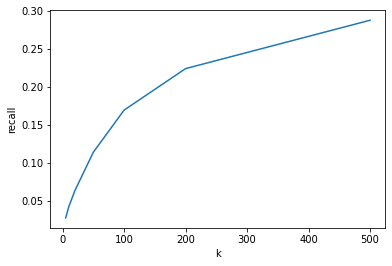

In [22]:
plt.plot(values, recall)
plt.ylabel('recall')
plt.xlabel('k')
plt.show()

**C)*** Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

Для того чтобы ответить на этот вопрос, построим, дополнительно, график precision_at_k.

In [23]:
precision = get_metrics(precision_at_k, values)

100%|██████████| 7/7 [01:25<00:00, 12.20s/it]


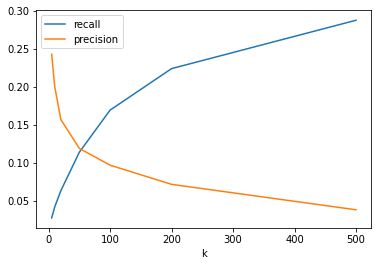

In [24]:
plt.plot(values, recall, label='recall')
plt.xlabel('k')
plt.plot(values, precision, label='precision')
plt.legend()
plt.show()

Видно, что с увеличением к-ва элементов recall  ростет, а precision уменьшается. Выбор значения k во монгом зависит от задачи, все завист от того какой параметр мы хотим максимизировать. 
Но, в общем случаем оптимальне значение k находится в месте пересечения графиков precision и recall, т.е. ~ 50.

### Задание 2.

Обучите модель 2-ого уровня, при этом:  
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар  
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2  
    - Вырос ли precision@5 при использовании двухуровневой модели?  

In [25]:
# data = data_train_lvl_2.copy()

In [26]:
# # data
# # day in week
# week_day = {'week_day': []}
# # считаем номер недели. поле чего вычисляем записи с номеро дня. 
# # определяем номер дня соответствуующий номеру последнему дню недели и после этого начинаем вычетать из него.
# # номера номера дней. 
# max_week_no = data['week_no'].max()
# min_week_no = data['week_no'].min()

# week_days=[]
# for week_no in range(min_week_no,max_week_no + 1):
#     max_day_in_week = data.loc[(data['week_no']==week_no),'day'].max()
#     days = data.loc[(data['week_no']==week_no),'day']
#     for day in days:
#         week_days.append(day-max_day_in_week+7)

# data['week_day'] = week_days

In [27]:
data

user_id    basket_id  day   item_id  quantity  sales_value  store_id  \
0           2375  26984851472    1   1004906         1         1.39       364   
1           2375  26984851472    1   1033142         1         0.82       364   
2           2375  26984851472    1   1036325         1         0.99       364   
3           2375  26984851472    1   1082185         1         1.21       364   
4           2375  26984851472    1   8160430         1         1.50       364   
...          ...          ...  ...       ...       ...          ...       ...   
2396799     1613  41655820646  663  16102849         1         2.00      3262   
2396800     1001  41655829421  663  13217063         1         1.69      3131   
2396801     1001  41655829421  663  13217800         1         1.69      3131   
2396802     1167  41656790510  663   6410462     22451        43.98      3385   
2396803     1167  41656790510  663   6430664         1         8.00      3385   

         retail_disc  trans_time  week_no  coupon_disc  coupon_match_disc  \
0              -0.60        1631        1          0.0                0.0   
1               0.00        1631        1          0.0                0.0   
2              -0.30        1631        1          0.0                0.0   
3               0.00        1631        1          0.0                0.0   
4              -0.39        1631        1          0.0                0.0   
...              ...         ...      ...          ...                ...   
2396799        -1.15        1231       95          0.0                0.0   
2396800         0.00        2231       95          0.0                0.0   
2396801         0.00        2231       95          0.0                0.0   
2396802        -0.65        1059       95          0.0                0.0   
2396803         0.00        1059       95          0.0                0.0   

         week_day  
0               3  
1               3  
2               3  
3               3  
4               3  
...           ...  
2396799         7  
2396800         7  
2396801         7  
2396802         7  
2396803         7  

[2396804 rows x 13 columns]

In [28]:
# data['week_day'].unique()

In [29]:
# data_gr = data.groupby('basket_id').sum()

In [30]:
# for i in [1,2,3,4,5,6,7]:
#     data_gr[f"day_{i}"] = np.where((data_gr[f"day_{i}"] > 0),1,0)

In [31]:
def user_features_pprepare(data, user_features):
    pass

In [32]:
data_gr = data.groupby('basket_id').mean()

In [33]:
# data_gr['user_id'] = data_gr['user_id'].apply(lambda x: int(x))

In [34]:
# data_gr.loc[(data_gr['user_id']==2494)]

In [35]:
user_features['median_quantity'] = user_features['user_id'].apply(lambda x: 
                                data_gr.loc[(data_gr['user_id']==x),'quantity'].median())
user_features['mean_sales_value'] = user_features['user_id'].apply(lambda x: 
                                data_gr.loc[(data_gr['user_id']==x),'sales_value'].mean())

In [36]:
for i in [1,2,3,4,5,6,7]:
    data_gr[f"day_{i}"] = np.where((data_gr['week_day'] == i),1,0)

In [37]:
# for i in [1,2,3,4,5,6,7]:
#     data_gr[f"day_{i}"] = np.where((data_gr[f"day_{i}"] > 0),1,0)

In [38]:
week_count = data['week_no'].max()

def mean_quantity_in_week(user_id):
    days = 0
    for i in [1,2,3,4,5,6,7]:
       days += data_gr.loc[(data_gr['user_id']==user_id),f'day_{i}'].sum()
    days /=week_count
    return int(np.round(days))

In [39]:
user_features['mean_quantity_in_week'] = user_features['user_id'].apply(lambda x: mean_quantity_in_week(x))

In [40]:
user_features

age_desc marital_status_code  income_desc homeowner_desc  \
0          65                   A           42      Homeowner   
1          50                   A           62      Homeowner   
2          30                   U           30        Unknown   
3          30                   U           87      Homeowner   
4          50                   B           62      Homeowner   
..        ...                 ...          ...            ...   
796        40                   U           62      Homeowner   
797        50                   A           87      Homeowner   
798        50                   U           42        Unknown   
799        30                   U           62      Homeowner   
800        30                   U           15        Unknown   

         hh_comp_desc household_size_desc kid_category_desc  user_id  \
0    2 Adults No Kids                   2      None/Unknown        1   
1    2 Adults No Kids                   2      None/Unknown        7   
2       2 Adults Kids                   3                 1        8   
3       2 Adults Kids                   4                 2       13   
4       Single Female                   1      None/Unknown       16   
..                ...                 ...               ...      ...   
796  2 Adults No Kids                   2      None/Unknown     2494   
797           Unknown                   3                 1     2496   
798       Single Male                   1      None/Unknown     2497   
799  2 Adults No Kids                   2      None/Unknown     2498   
800     2 Adults Kids                   3                 1     2499   

     median_quantity  mean_sales_value  mean_quantity_in_week  
0           1.100000          2.726818                      1  
1           1.181818          2.989986                      1  
2           1.172222          4.734543                      1  
3           1.666667         19.434575                      3  
4           1.000000          4.401541                      1  
..               ...               ...                    ...  
796         1.320513          5.740227                      0  
797         1.307304          7.811230                      1  
798         1.333333          3.981373                      2  
799         1.000000          3.855324                      2  
800         1.100000          7.028010                      1  

[801 rows x 11 columns]

In [31]:
item_features

item_id  manufacturer    department     brand  \
0         25671             2       GROCERY  National   
1         26081             2  MISC. TRANS.  National   
2         26093            69        PASTRY   Private   
3         26190            69       GROCERY   Private   
4         26355            69       GROCERY   Private   
...         ...           ...           ...       ...   
92348  18293142          6384       DRUG GM  National   
92349  18293439          6393       DRUG GM  National   
92350  18293696          6406       DRUG GM  National   
92351  18294080          6442       DRUG GM  National   
92352  18316298           764       GROCERY  National   

                 commodity_desc           sub_commodity_desc  \
0                      FRZN ICE          ICE - CRUSHED/CUBED   
1      NO COMMODITY DESCRIPTION  NO SUBCOMMODITY DESCRIPTION   
2                         BREAD         BREAD:ITALIAN/FRENCH   
3          FRUIT - SHELF STABLE                  APPLE SAUCE   
4                 COOKIES/CONES            SPECIALTY COOKIES   
...                         ...                          ...   
92348                 BOOKSTORE              PAPERBACK BOOKS   
92349                 BOOKSTORE            CHILDRENS LOW END   
92350                 BOOKSTORE        PAPERBACK BEST SELLER   
92351                 BOOKSTORE              PAPERBACK BOOKS   
92352              PAPER TOWELS       PAPER TOWELS & HOLDERS   

      curr_size_of_product  
0                    22 LB  
1                           
2                           
3                    50 OZ  
4                    14 OZ  
...                    ...  
92348                       
92349                       
92350                       
92351                       
92352                       

[92353 rows x 7 columns]

In [35]:
item_features_temp = item_features.merge(data, on='item_id', how='left')

In [48]:
# Средняя стоимость товара в категории.

item_price = item_features_temp.groupby(['item_id','commodity_desc'])['sales_value'].mean().reset_index()
item_price.columns= ['item_id','commodity_desc','sales_value']
commoditys_desc = item_price['commodity_desc'].unique()

item_price['commodity_desc_mean_sale']=np.NaN

for commodity_desc in commoditys_desc:
    mean_value = item_price.loc[(item_price['commodity_desc']==commodity_desc),'sales_value'].mean()
    item_price.loc[(item_price['commodity_desc']==commodity_desc),'commodity_desc_mean_sale'] = mean_value
# item_features_temp.loc[(item_features_temp['commodity_desc']=='NO COMMODITY DESCRIPTION'),'sales_value']
item_price.loc[(item_price['commodity_desc']=='NO COMMODITY DESCRIPTION'),'sales_value']
# item_price
item_features = item_features.merge(item_price[['item_id','commodity_desc_mean_sale']], on='item_id',how='left')

In [66]:
# К-во покупок в неделю.

quantity_count = item_features_temp.groupby(['item_id'])['quantity'].sum().reset_index()

quantity_count.columns = ['item_id','quantity']
# data.loc[(data['item_id']==25671)]
# quantity_count
quantity_in_week = item_features_temp.groupby(['item_id'])['week_no'].unique().reset_index()

quantity_in_week.columns = ['item_id','weeks']
# quantity_in_week
quantity_in_week['weeks_count'] = quantity_in_week['weeks'].apply(lambda x: len(x))
# item_feature_temp = item_feature_temp.merge(if_week, on='item_id', how='left')
quantity_in_week['sale_in_week'] = quantity_count['quantity']/quantity_in_week['weeks_count']  
# quantity_in_week
item_features = item_features.merge(quantity_in_week[['item_id','sale_in_week']], on='item_id',how='left')

In [ ]:
# Для нас нет необходимости добавлять все фитчи users и items.

In [85]:
def perpare_lvl2(data,N=50):
    users_lvl_2 = pd.DataFrame(data['user_id'].unique()) # Добавим туда еще фитчи user-ов и item-ов.
    users_lvl_2.columns = ['user_id']

    # Пока только warm start
    users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(data_train_lvl_1['user_id'].unique())]

    # Заполняем кандидатов, на основе предсказания модели 1-го уровня.
    users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=N))
    # test_users = data
    s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
    s.name = 'item_id'

    # Это кандидаты. (т.е. предпологаемые покупки совершенные на основе предсказаний.)
    users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
    users_lvl_2['drop'] = 1  # фиктивная переменная

    # Создадим таблицу с реальными покупками user-ов. 
    targets_lvl_2 = data[['user_id', 'item_id']].copy()
    targets_lvl_2['target'] = 1  # тут только покупки 

    # Объединим предпологаемые покупки с реальными, совершенными user-ами.
    targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

    # В результате, напротив товаров, в редсказании которых мы ошиблись, 
    # будет стоять Nan. Заполним их  нулями.  
    targets_lvl_2['target'].fillna(0, inplace= True)
    targets_lvl_2.drop('drop', axis=1, inplace=True)
    targets_lvl_2['target'].mean() #Угадали примерно 17% покупок.

    # Добавим к нашему датасету фичи user-ов и item-ов.
    targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
    targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

    X_ = targets_lvl_2.drop('target', axis=1)
    y_ = targets_lvl_2[['target']]
    return X_, y_ 

In [86]:
X_train, y_train = perpare_lvl2(data_train_lvl_2)

In [87]:
X_test, y_test = perpare_lvl2(data_val_lvl_2)

In [88]:
X_train.head(2)

user_id  item_id  manufacturer department     brand commodity_desc  \
0     2070   834103          2224    GROCERY  National    SOFT DRINKS   
1     2070   834103          2224    GROCERY  National    SOFT DRINKS   

               sub_commodity_desc curr_size_of_product  \
0  SFT DRNK SNGL SRV BTL CARB (EX                20 OZ   
1  SFT DRNK SNGL SRV BTL CARB (EX                20 OZ   

   commodity_desc_mean_sale  age_desc marital_status_code  income_desc  \
0                  2.705525      50.0                   U         62.0   
1                  2.705525      50.0                   U         62.0   

  homeowner_desc hh_comp_desc household_size_desc kid_category_desc  
0        Unknown      Unknown                   1      None/Unknown  
1        Unknown      Unknown                   1      None/Unknown

In [89]:
cat_feats = X_train.columns[2:].tolist()

X_train[cat_feats] = X_train[cat_feats].astype('category')

X_test[cat_feats] = X_test[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'commodity_desc_mean_sale',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [90]:
y_train.mean()

target    0.178224
dtype: float64

In [156]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=7,
                     categorical_column=cat_feats
                     )
                     
lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)[:,1]

C:\Users\eveli\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\eveli\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\eveli\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


In [157]:
train_preds

array([9.99966042e-01, 9.99966042e-01, 9.99966042e-01, ...,
       8.01075740e-06, 8.01075740e-06, 8.01075740e-06])

In [158]:
y_train['target'].values

array([1., 1., 1., ..., 0., 0., 0.])

In [159]:
x_train_t = X_train.copy()
x_train_t['predict'] = train_preds
x_train_t['true'] = y_train['target'].values
result = x_train_t.sort_values('predict', ascending=False).groupby('user_id')['item_id'].unique().reset_index()

In [160]:
overall_top_purchases = x_train_t.groupby('item_id')['item_id'].count()
overall_top_purchases = overall_top_purchases.sort_values(ascending=False).index.values

In [161]:
def extend_with_top_popular(recommendations, N=5):
    """Если кол-во рекоммендаций < N, то дополняем их топ-популярными"""

    if len(recommendations) < N:
        recommendations.extend(overall_top_purchases[:N])
        recommendations = recommendations[:N]

    return recommendations

In [ ]:
def get_items(x_data, data, user_id, item_name,is_extend=True):
    items_list = []
    items = data.loc[(data['user_id']==user_id),'item_id'].values[0]

    for item in items:
        flag = x_data.loc[((x_data['user_id']==user_id) & (x_data['item_id']==item)),item_name].mean()
        if np.round(flag):
            items_list.append(item)
    if is_extend:
        items_list = extend_with_top_popular(items_list, N=5)
    return items_list

In [145]:
# def get_items_1(x_data, items, user_id, item_name, is_extend=True):
#     items_list = []

#     for item in items:
#         flag = (x_data.loc[((x_data['user_id']==user_id) & (x_train_t['item_id']==item)),item_name].mean())
        
#         if np.round(flag): # Округляем прдсказанную вероятность до целого.
#             items_list.append(item)
#     if is_extend:
#         items_list = extend_with_top_popular(items_list, N=5)
#     return items_list

In [140]:
# precisions=[]
# for res in tqdm(result.iterrows()):
#     user_id = res[1]['user_id']
#     item_ids = res[1]['item_id']
#     predict = get_items_1(x_train_t, item_ids, user_id, 'predict', is_extend=True)
#     true = get_items_1(x_train_t,item_ids, user_id, 'true', is_extend=False)
#     precisions.append(precision_at_k(predict,true,5)) 
    
# np.mean(precisions)

2084it [02:42, 12.83it/s]


In [162]:
item_name = 'predict'
result[item_name] = result['user_id'].progress_apply(lambda x : get_items(x_train_t, result, x, item_name,is_extend=True))

item_name = 'true'
result[item_name] = result['user_id'].progress_apply(lambda x : get_items(x_train_t, result, x, item_name,is_extend=False))

precisions=[]
for res in result.iterrows():
    predict = res[1]['predict']
    true = res[1]['true']
    precisions.append(precision_at_k(predict,true,5))

100%|██████████| 2084/2084 [01:10<00:00, 29.46it/s]


In [163]:
np.mean(precisions)

0.695873320537428

### Проверка на тестовой выборке.

In [142]:
test_preds = lgb.predict_proba(X_test)[:,1]

In [143]:
x_test_t = X_test.copy()
x_test_t['predict'] = test_preds
x_test_t['true'] = y_test['target'].values
result = x_test_t.sort_values('predict', ascending=False).groupby('user_id')['item_id'].unique().reset_index()

In [ ]:
# precisions=[]
# for res in tqdm(result.iterrows()):
#     user_id = res[1]['user_id']
#     item_ids = res[1]['item_id']
#     predict = get_items_1(x_test_t, item_ids, user_id, 'predict', is_extend=True)
#     true = get_items_1(x_test_t, item_ids, user_id, 'true', is_extend=False)
#     precisions.append(precision_at_k(predict,true,5)) 
    
# np.mean(precisions)

In [153]:
item_name = 'predict'
result[item_name] = result['user_id'].progress_apply(lambda x : get_items(x_test_t, result, x, item_name,is_extend=True))

item_name = 'true'
result[item_name] = result['user_id'].progress_apply(lambda x : get_items(x_test_t, result, x, item_name,is_extend=False))

precisions=[]
for res in result.iterrows():
    predict = res[1]['predict']
    true = res[1]['true']
    precisions.append(precision_at_k(predict,true,5))

100%|██████████| 1968/1968 [01:06<00:00, 29.69it/s]


In [154]:
np.mean(precisions)

0.1298780487804878

In [ ]:
item_features = item_features.merge(item_price[['item_id','commodity_desc_mean_sale']], on='item_id',how='left')

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 25%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 